In [1]:
import kagglehub

In [2]:
# Download latest version
path = kagglehub.dataset_download("pythonafroz/solar-panel-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/solar-panel-images


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import random
from cv2 import resize
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [17]:
img_height = 244
img_width = 244
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/solar-panel-images/Faulty_solar_panel',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/solar-panel-images/Faulty_solar_panel',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

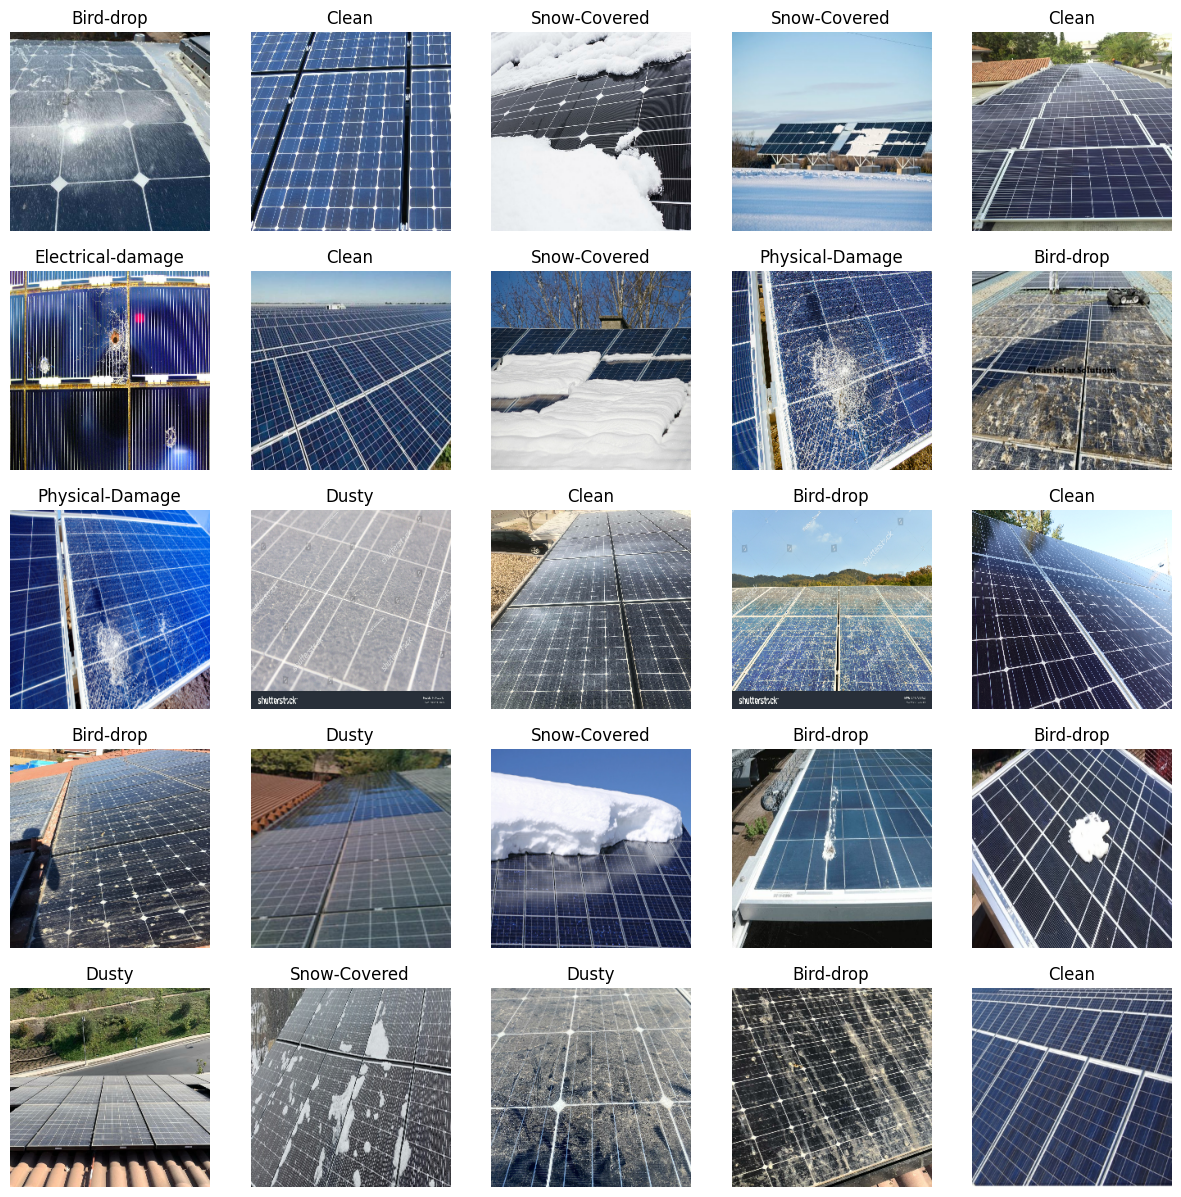

In [6]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [21]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds1 = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds1 = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [33]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers

input_shape = (img_height, img_width, 3)

model = models.Sequential([
    # Preprocessing
    layers.Rescaling(1./255, input_shape=input_shape),

    # Convert to flat vector
    layers.Flatten(),

    # First block
    layers.Dense(1024, activation=None, kernel_regularizer=regularizers.l2(0.0001)),
    layers.LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second block
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Third block
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Fourth block
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Output layer
    layers.Dense(6, activation='softmax')
])


model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


from sklearn.utils.class_weight import compute_class_weight
import numpy as np


all_labels = []
for _, labels in train_ds1:
    all_labels.extend(labels.numpy())

class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


history = model.fit(
    train_ds1,
    validation_data=val_ds1,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping]
)

model.save("solar_fault_model2.h5")

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 632ms/step - accuracy: 0.1807 - loss: 2.6291 - val_accuracy: 0.2429 - val_loss: 2.1180 - learning_rate: 5.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.3008 - loss: 2.3553 - val_accuracy: 0.2429 - val_loss: 2.1319 - learning_rate: 5.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 502ms/step - accuracy: 0.3574 - loss: 2.1560 - val_accuracy: 0.2542 - val_loss: 2.1170 - learning_rate: 5.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - accuracy: 0.4092 - loss: 2.0111 - val_accuracy: 0.3107 - val_loss: 2.1441 - learning_rate: 5.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 440ms/step - accuracy: 0.4111 - loss: 1.9051 - val_accuracy: 0.3672 - val_loss: 2.0718 - learning_rate: 5.0000e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - accuracy: 0.3837 - loss: 1.9659 - val_accuracy: 0.3842 - val_loss: 2.0824 - learning_rate: 5.0000e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 463ms/step - accu

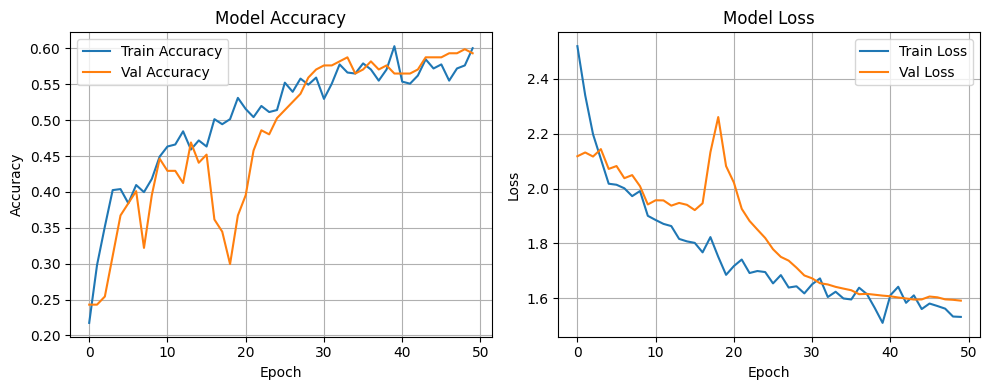

In [34]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
loss, accuracy = model.evaluate(val_ds1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.5858 - loss: 1.6315


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


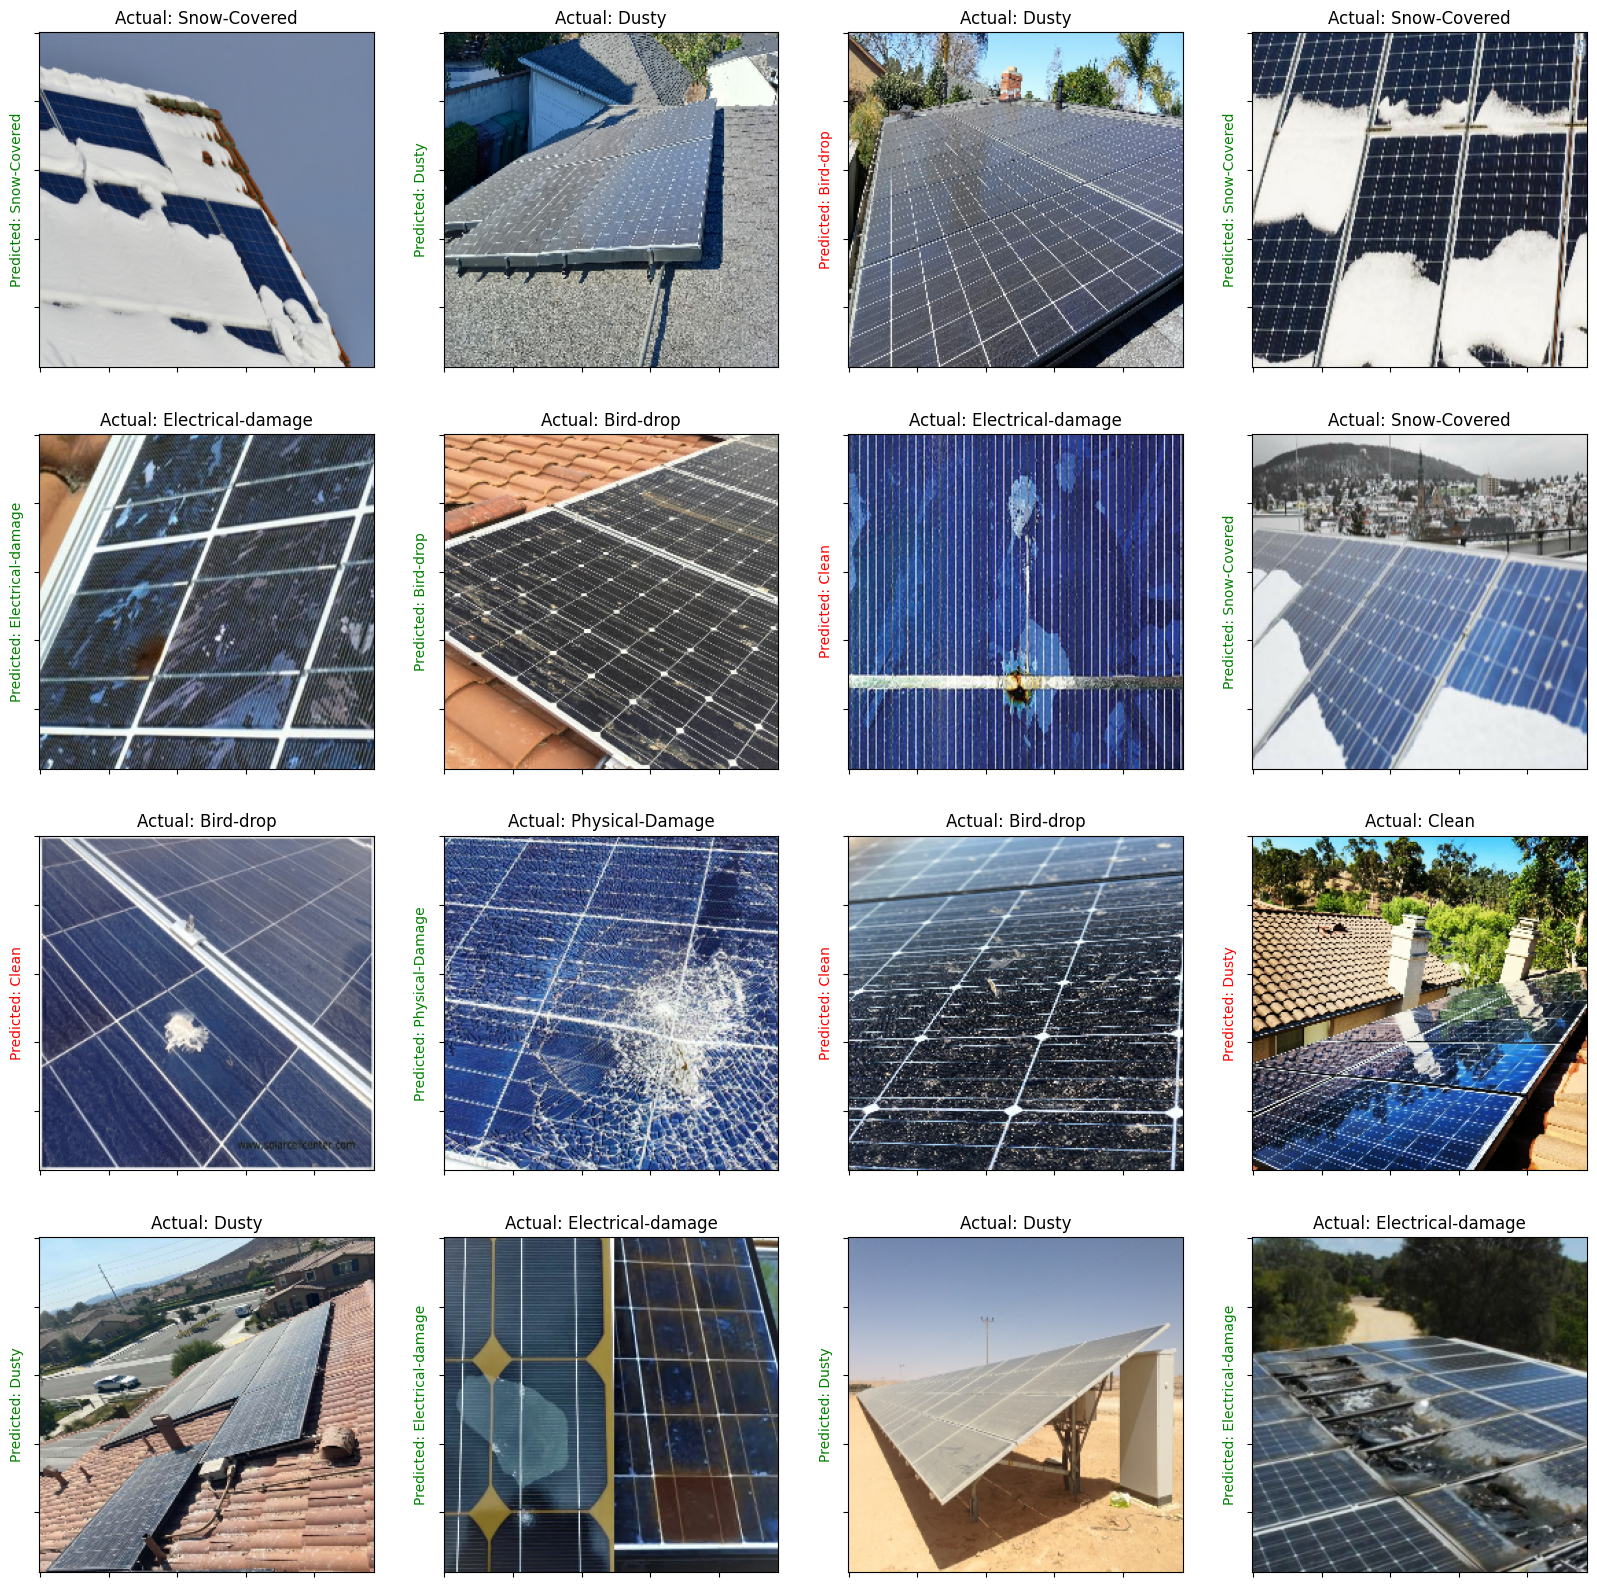

In [40]:
plt.figure(figsize=(20, 20))
for images, labels in val_ds1.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)

        # Convert normalized values back to 0-255 range
        display_image = images[i].numpy() * 255
        display_image = display_image.astype("uint8")

        plt.imshow(display_image)
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])